In [110]:
import os
import shutil
import yaml

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import cv2

import argparse
import re
from tqdm import tqdm

from src.utils.helpers import makedir
from src.models import seg_model
from src.training import push
from src.training import prune
from src.training import train_and_test as tnt

from src.utils import save
from src.utils.log import create_logger
import logging
from src.data.raman_dataset import get_new_raman_path, create_raman_mask_dataloaders_from_ids

import matplotlib.pyplot as plt

In [111]:
logging.basicConfig(level=logging.INFO)

In [113]:
model_path = "out_model/saved_models/resnet18/good_projection_trial_0/11_0push0.7119.pth"
# load the model
model = torch.load(model_path)
model

/tmp/ipykernel_3815145/4043621072.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


PPNet(
	features: resnet18_features,
	img_size: 512,
	prototype_shape: (30, 64, 1, 1),
	proto_layer_rf_info: [16, 32, 435, 0.5],
	num_classes: 2,
	epsilon: 0.0001
)

In [114]:
# config for training
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)
conf["training"]["stride"] = [512, 512]

# Check generation

In [115]:
def collect_raman_channels(raman_id):
    """
    Load and combine SRS, DC, and AUX channels into a single torch tensor.

    Channels:
     - 0-20: SRS
     - 21   : DC
     - 22-23: AUX

    Returns:
        torch.FloatTensor of shape (24, H, W)
    """
    # get the paths to your data files
    raman_paths = get_new_raman_path(raman_id)

    # load SRS-normalized data (shape: H x W x C>=24)
    srs_norm_np = np.load(raman_paths["srs_norm"], mmap_mode='r')
    H, W = srs_norm_np.shape[:2]

    # extract the 21 SRS channels (0–20) and the 2 AUX channels (22–23)
    srs = srs_norm_np[:, :, :21]  # (H, W, 21)
    aux = srs_norm_np[:, :, 22:24]  # (H, W,  2)

    # load raw DC data (e.g. H x W x N), collapse the 3rd dim by mean
    dc_orig_np = np.load(raman_paths["dc_orig"], mmap_mode='r')
    dc = np.mean(dc_orig_np, axis=2)  # (H, W)

    # convert to torch and reorder to (C, H, W)
    srs_t = torch.from_numpy(srs).float().permute(2, 0, 1)  # (21, H, W)
    dc_t = torch.from_numpy(dc).float().unsqueeze(0)  # ( 1, H, W)
    aux_t = torch.from_numpy(aux).float().permute(2, 0, 1)  # ( 2, H, W)

    # normalize DC to [0,1]
    dc_min, dc_max = dc_t.min(), dc_t.max()
    if dc_max > dc_min:
        dc_t = (dc_t - dc_min) / (dc_max - dc_min)
    else:
        dc_t = dc_t - dc_min

    # stack into (24, H, W)
    combined = torch.cat([srs_t, dc_t, aux_t], dim=0)
    return combined


In [116]:
raman_id = 'E919-24_sample2_1'
raman_channels = collect_raman_channels(raman_id)
raman_channels.shape

torch.Size([24, 4608, 9984])

In [117]:
def load_gt_mask(raman_id, new_w, new_h):
    gt_mask_path = f"/home/ct678/aligned_masks/{raman_id}.npy"
    gt_mask = np.load(gt_mask_path, mmap_mode='r')
    gt_mask = cv2.resize(gt_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    gt_mask[gt_mask == 1] = 1
    gt_mask[gt_mask == 4] = 1
    gt_mask[gt_mask == 15] = 1
    gt_mask[gt_mask != 1] = 0
    return gt_mask

gt_mask = load_gt_mask(raman_id, raman_channels.shape[2], raman_channels.shape[1])

In [118]:
ph, pw = conf["training"]["patch_size"]
def patchify(big_img_chw):
    """
    Patchifies an image (C, H, W) into patches (N, C, ph, pw).
    Note: This version crops the image if H or W are not multiples of ph or pw.
    """
    C, H, W = big_img_chw.shape
    # Calculate how many patches fit along height and width
    num_patches_h = H // ph
    num_patches_w = W // pw

    # Crop the image to the largest size that is perfectly divisible
    cropped_h = num_patches_h * ph
    cropped_w = num_patches_w * pw
    cropped_img = big_img_chw[:, :cropped_h, :cropped_w]

    # unfold expects (C, H, W)
    # Output of unfold: (C, num_blocks_h, num_blocks_w, ph, pw)
    patches = cropped_img.unfold(1, ph, ph).unfold(2, pw, pw)
    # patches shape: (C, num_patches_h, num_patches_w, ph, pw)

    # Permute and reshape to (num_patches_h * num_patches_w, C, ph, pw)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()
    # patches shape: (num_patches_h, num_patches_w, C, ph, pw)
    patches = patches.view(-1, C, ph, pw)
    # patches shape: (num_total_patches, C, ph, pw)
    return patches, (C, cropped_h, cropped_w) # Return patches and the shape they can reconstruct

def unpatchify(patches, reconstructed_shape_chw):
    """
    Reconstructs the image from patches.
    patches: (N, C, ph, pw)
    reconstructed_shape_chw: The target shape (C, H_reconstructed, W_reconstructed)
                             This should be the shape of the image that was patchified
                             (i.e., potentially cropped original image).
    """
    C, H_reconstructed, W_reconstructed = reconstructed_shape_chw
    num_patches_h = H_reconstructed // ph
    num_patches_w = W_reconstructed // pw

    if patches.shape[0] != num_patches_h * num_patches_w:
        raise ValueError(f"Number of patches {patches.shape[0]} does not match "
                         f"expected {num_patches_h * num_patches_w} for shape {reconstructed_shape_chw}")
    if patches.shape[1] != C:
        raise ValueError(f"Patch channel count {patches.shape[1]} does not match "
                         f"expected {C} for shape {reconstructed_shape_chw}")


    # Reshape to (num_patches_h, num_patches_w, C, ph, pw)
    patches = patches.view(num_patches_h, num_patches_w, C, ph, pw)

    # Permute to (C, num_patches_h, ph, num_patches_w, pw)
    # This groups patch data by channel, then by patch rows, then patch content height,
    # then by patch columns, then patch content width.
    rearranged = patches.permute(2, 0, 3, 1, 4).contiguous()

    # Reshape to (C, H_reconstructed, W_reconstructed)
    return rearranged.view(C, H_reconstructed, W_reconstructed)

In [9]:
patched_raman, recon_shape = patchify(raman_channels)
patched_raman.shape, recon_shape

(torch.Size([171, 24, 512, 512]), (24, 4608, 9728))

In [10]:
seg_mask_patches = torch.zeros(patched_raman.shape[0], 1, ph, pw)
for i, patch in tqdm(enumerate(patched_raman), desc="Processing patches"):
    patch = patch.cuda()
    with torch.inference_mode():
        patch = patch.unsqueeze(0)
        logits, _ = model(patch)
        pred = torch.argmax(logits, dim=1).squeeze(0)
    seg_mask_patches[i, 0] = pred
seg_mask = unpatchify(seg_mask_patches, (1, *recon_shape[1:]))
seg_mask.shape

Processing patches: 0it [00:00, ?it/s]

Processing patches: 171it [00:01, 92.13it/s] 


torch.Size([1, 4608, 9728])

In [11]:
cropped_gt_mask = gt_mask[:seg_mask.shape[1], :seg_mask.shape[2]]
intersection = np.sum(seg_mask.squeeze().numpy() * cropped_gt_mask.squeeze())
union = np.sum(seg_mask.squeeze().numpy()) + np.sum(cropped_gt_mask.squeeze())
dice_score = 2 * intersection / union if union > 0 else 0
print(f"Dice score: {dice_score:.4f}")

Dice score: 0.7100


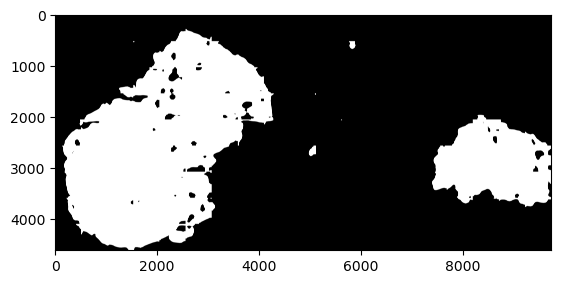

In [12]:
plt.imshow(seg_mask[0].cpu().numpy(), cmap='gray')

# Mean Dice Score on Val/Test

In [13]:
holdout_ids = [
    "E119-24_sample1_1-half1",
    "E119-24_sample1_2",
    "E119-24_sample2_1_half1",
    "E119-24_sample2_1_half2",
    "E919-24_sample1_1",
    "E919-24_sample1_2",
    "E919-24_sample2_1",
    "E919-24_sample2_2",
] + [
    "E341-24_sample3",
    "E341-24_sample4",
    "E341-24_sample5",
    "E341-24_sample6",
    "E341-24_sample7",
]

In [14]:
def calculate_dice_score(pred_mask, gt_mask):
    """
    Calculates the Dice similarity coefficient.

    Args:
        pred_mask (np.ndarray): The predicted segmentation mask.
        gt_mask (np.ndarray): The ground truth mask.

    Returns:
        float: The Dice score.
    """
    intersection = np.sum(pred_mask * gt_mask)
    union = np.sum(pred_mask) + np.sum(gt_mask)
    dice = (2.0 * intersection) / union if union > 0 else 0.0
    return dice

def calculate_sensitivity(pred_mask, gt_mask):
    """
    Calculates the sensitivity (true positive rate).

    Args:
        pred_mask (np.ndarray): The predicted segmentation mask.
        gt_mask (np.ndarray): The ground truth mask.

    Returns:
        float: The sensitivity score.
    """
    true_positives = np.sum(pred_mask * gt_mask)
    actual_positives = np.sum(gt_mask)
    sensitivity = true_positives / actual_positives if actual_positives > 0 else 0.0
    return sensitivity

def calculate_specificity(pred_mask, gt_mask):
    """
    Calculates the specificity (true negative rate).

    Args:
        pred_mask (np.ndarray): The predicted segmentation mask.
        gt_mask (np.ndarray): The ground truth mask.

    Returns:
        float: The specificity score.
    """
    true_negatives = np.sum((1 - pred_mask) * (1 - gt_mask))
    actual_negatives = np.sum(1 - gt_mask)
    specificity = true_negatives / actual_negatives if actual_negatives > 0 else 0.0
    return specificity

In [15]:
dice_scores, sens, specs = [], [], []
for raman_id in holdout_ids:
    raman_channels = collect_raman_channels(raman_id)
    gt_mask = load_gt_mask(raman_id, raman_channels.shape[2], raman_channels.shape[1])
    patched_raman, recon_shape = patchify(raman_channels)

    seg_mask_patches = torch.zeros(patched_raman.shape[0], 1, ph, pw)
    for i, patch in tqdm(enumerate(patched_raman), desc=f"Processing patches for {raman_id}"):
        patch = patch.cuda()
        with torch.inference_mode():
            patch = patch.unsqueeze(0)
            logits, _ = model(patch)
            pred = torch.argmax(logits, dim=1).squeeze(0)
        seg_mask_patches[i, 0] = pred
    seg_mask = unpatchify(seg_mask_patches, (1, *recon_shape[1:]))
    padded_seg_mask = torch.zeros(gt_mask.shape[0], gt_mask.shape[1])
    padded_seg_mask[:seg_mask.shape[1], :seg_mask.shape[2]] = seg_mask.squeeze(0).cpu()

    dice_score = calculate_dice_score(padded_seg_mask.numpy(), gt_mask)
    sensitivity = calculate_sensitivity(padded_seg_mask.numpy(), gt_mask)
    specificity = calculate_specificity(padded_seg_mask.numpy(), gt_mask)

    dice_scores.append(dice_score)
    sens.append(sensitivity)
    specs.append(specificity)
    print(f"Raman ID: {raman_id}, Dice: {dice_score:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
print(f"Average Dice score: {np.mean(dice_scores):.4f}")
print(f"Average Sensitivity: {np.mean(sens):.4f}")
print(f"Average Specificity: {np.mean(specs):.4f}")

Processing patches for E119-24_sample1_1-half1: 180it [00:00, 185.40it/s]


Raman ID: E119-24_sample1_1-half1, Dice: 0.4938, Sensitivity: 0.9719, Specificity: 0.7491


Processing patches for E119-24_sample1_2: 72it [00:00, 189.54it/s]


Raman ID: E119-24_sample1_2, Dice: 0.3318, Sensitivity: 0.9162, Specificity: 0.7120


Processing patches for E119-24_sample2_1_half1: 180it [00:01, 127.14it/s]


Raman ID: E119-24_sample2_1_half1, Dice: 0.6426, Sensitivity: 0.9399, Specificity: 0.8055


Processing patches for E119-24_sample2_1_half2: 180it [00:01, 175.86it/s]


Raman ID: E119-24_sample2_1_half2, Dice: 0.4465, Sensitivity: 0.9137, Specificity: 0.8677


Processing patches for E919-24_sample1_1: 128it [00:00, 175.92it/s]


Raman ID: E919-24_sample1_1, Dice: 0.7001, Sensitivity: 0.8948, Specificity: 0.8143


Processing patches for E919-24_sample1_2: 105it [00:00, 184.22it/s]


Raman ID: E919-24_sample1_2, Dice: 0.7349, Sensitivity: 0.9883, Specificity: 0.7406


Processing patches for E919-24_sample2_1: 171it [00:00, 188.60it/s]


Raman ID: E919-24_sample2_1, Dice: 0.7100, Sensitivity: 0.9900, Specificity: 0.8471


Processing patches for E919-24_sample2_2: 171it [00:00, 182.55it/s]


Raman ID: E919-24_sample2_2, Dice: 0.7146, Sensitivity: 0.9521, Specificity: 0.8714


Processing patches for E341-24_sample3: 110it [00:00, 182.89it/s]


Raman ID: E341-24_sample3, Dice: 0.6483, Sensitivity: 0.9886, Specificity: 0.7862


Processing patches for E341-24_sample4: 110it [00:00, 189.25it/s]


Raman ID: E341-24_sample4, Dice: 0.6150, Sensitivity: 0.9996, Specificity: 0.7437


Processing patches for E341-24_sample5: 110it [00:00, 174.77it/s]


Raman ID: E341-24_sample5, Dice: 0.6245, Sensitivity: 0.9918, Specificity: 0.7765


Processing patches for E341-24_sample6: 110it [00:00, 174.15it/s]


Raman ID: E341-24_sample6, Dice: 0.6109, Sensitivity: 0.9936, Specificity: 0.7640


Processing patches for E341-24_sample7: 99it [00:00, 159.59it/s]


Raman ID: E341-24_sample7, Dice: 0.6071, Sensitivity: 0.9621, Specificity: 0.7617
Average Dice score: 0.6062
Average Sensitivity: 0.9617
Average Specificity: 0.7877


In [17]:
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
print(f"Mean Dice score: {dice_mean:.4f}, Std: {dice_std:.4f}")
sens_mean, sens_std = np.mean(sens), np.std(sens)
print(f"Mean Sensitivity: {sens_mean:.4f}, Std: {sens_std:.4f}")
specs_mean, specs_std = np.mean(specs), np.std(specs)
print(f"Mean Specificity: {specs_mean:.4f}, Std: {specs_std:.4f}")

Mean Dice score: 0.6062, Std: 0.1126
Mean Sensitivity: 0.9617, Std: 0.0341
Mean Specificity: 0.7877, Std: 0.0486


# Patch Interp

In [119]:
raman_id = 'E919-24_sample2_1'
hne_path = f"/home/ct678/code/charm_data/aligned_hne/{raman_id}_align_hne.npy"
hne = np.load(hne_path, mmap_mode='r+')
hne = cv2.resize(hne, (raman_channels.shape[2], raman_channels.shape[1]), interpolation=cv2.INTER_LINEAR)
hne.shape

(4608, 9984, 3)

In [120]:
selected_pixel_x, selected_pixel_y = 142, 342

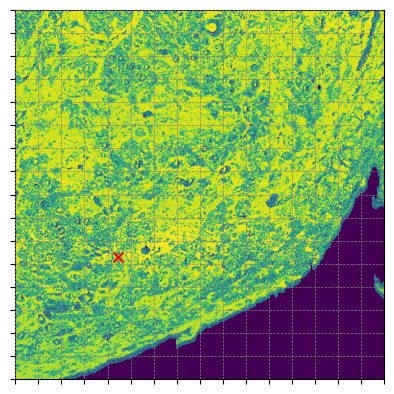

In [121]:
selected_patch = raman_channels[:, 4000:4000+512, 1750:1750+512]
selected_hne_patch = hne[4000:4000+512, 1750:1750+512]
selected_gt_mask = gt_mask[4000:4000+512, 1750:1750+512]

plt.imshow(selected_patch[0].cpu().numpy())
plt.scatter(selected_pixel_x, selected_pixel_y, color='red', s=50, marker='x')
height, width = selected_hne_patch.shape[:2]

# Set ticks to create 16x16 grid
plt.xticks(np.linspace(0, width, 17))
plt.yticks(np.linspace(0, height, 17))

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(False)

plt.show()

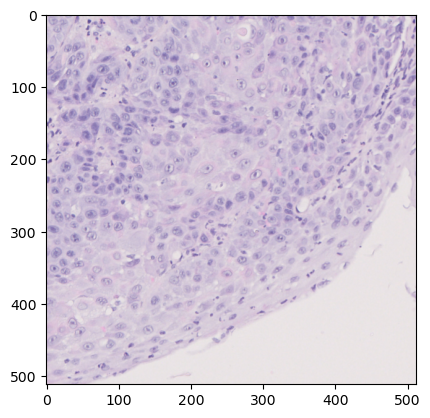

In [134]:
plt.imshow(selected_hne_patch)
plt.show()

In [122]:
with torch.inference_mode():
    patch_cuda = selected_patch.unsqueeze(0).cuda()
    logits, score_map = model(patch_cuda)
    _, dists = model.push_forward(patch_cuda)
    similarity_map = model.distance_2_similarity(dists).squeeze(0).cpu()
    pred = torch.argmax(logits, dim=1).squeeze(0)
pred.shape, similarity_map.shape

(torch.Size([512, 512]), torch.Size([30, 16, 16]))

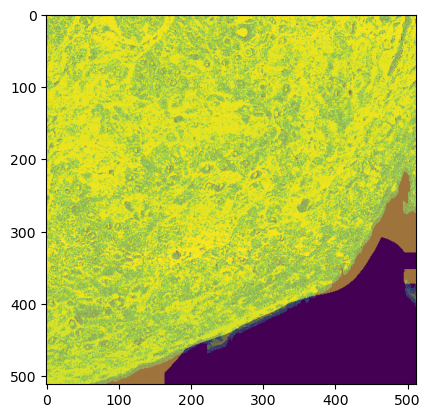

In [132]:
plt.imshow(selected_patch[0].cpu().numpy())
plt.imshow(pred.cpu().numpy(), alpha=0.5)

In [125]:
# %%
map_pos_x, map_pos_y = selected_pixel_x // 32, selected_pixel_y // 32
print(map_pos_x, map_pos_y)
similarities = similarity_map[:, map_pos_y, map_pos_x].cuda()
with torch.inference_mode():
    class_probs = model.last_layer(similarities.view(-1, 1, 1)).cpu().numpy()

4 10


In [126]:
last_layer_weights = model.last_layer.weight.data.cpu().numpy()
top_similarities, top_prototype_indices = torch.topk(similarities, k=30)
top_similarities, top_prototype_indices

(tensor([2.1677, 2.0045, 1.6600, 1.5155, 1.2953, 1.2362, 1.0462, 1.0298, 0.9145,
         0.8948, 0.8895, 0.8683, 0.7952, 0.7788, 0.7752, 0.7608, 0.7541, 0.7450,
         0.7328, 0.6433, 0.6328, 0.6011, 0.5574, 0.5455, 0.5415, 0.5121, 0.1754,
         0.0634, 0.0487, 0.0315], device='cuda:0'),
 tensor([22, 28, 16,  8, 19, 21, 20, 25,  2, 27, 11, 15,  9, 23, 10, 26, 13, 17,
         12,  7, 24, 14,  0,  1,  6,  5,  4, 18, 29,  3], device='cuda:0'))

In [127]:
last_layer_weights[:, top_prototype_indices.cpu(), 0, 0] @ top_similarities.cpu().numpy()

# %% [markdown]
# This makes sense, out of the existing prototypes, it's likely closer to tumorous regions, and as we saw from the class proportions, the model hadn't properly identified the epithelium as a characteristic region. This does make things interpretable: if with more training the model identifies such a region, we can be more confident that such false positives will be avoided.

array([ 2.4584603, 10.14997  ], dtype=float32)